载入实验需要的 Python 包：

In [116]:
import os
import re
import numpy as np
from collections import defaultdict

import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from gensim.models import KeyedVectors
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [101]:
seed = 622

## 数据预处理

将数据集转化成特征和标签：

In [102]:
def load_data_from_directory(directory_path):
    texts = []
    labels = []
    categories = sorted(os.listdir(directory_path))  # 按类别名称排序
    category_map = {category: index for index, category in enumerate(categories)}
    
    for category in categories:
        category_path = os.path.join(directory_path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                with open(file_path, 'r', encoding='latin-1') as file:
                    try:
                        content = file.read()
                        texts.append(content)
                        labels.append(category_map[category])
                    except Exception as e:
                        print(f"Error reading file {file_path}: {e}")
    
    return texts, labels, category_map


data_directory = "Data/20_newsgroups"
texts, labels, category_map = load_data_from_directory(data_directory)

print("加载完成，文档总数：", len(texts))
print("类别映射：", category_map)


加载完成，文档总数： 19997
类别映射： {'.DS_Store': 0, 'alt.atheism': 1, 'comp.graphics': 2, 'comp.os.ms-windows.misc': 3, 'comp.sys.ibm.pc.hardware': 4, 'comp.sys.mac.hardware': 5, 'comp.windows.x': 6, 'misc.forsale': 7, 'rec.autos': 8, 'rec.motorcycles': 9, 'rec.sport.baseball': 10, 'rec.sport.hockey': 11, 'sci.crypt': 12, 'sci.electronics': 13, 'sci.med': 14, 'sci.space': 15, 'soc.religion.christian': 16, 'talk.politics.guns': 17, 'talk.politics.mideast': 18, 'talk.politics.misc': 19, 'talk.religion.misc': 20}


In [103]:
# 统计标签分布
from collections import Counter
label_counter = Counter(labels)
for i in range(1, len(category_map), 10):
    for j in range(10):
        print(f"{i+j}: {label_counter[i+j]}", end='; ')
    print()

1: 1000; 2: 1000; 3: 1000; 4: 1000; 5: 1000; 6: 1000; 7: 1000; 8: 1000; 9: 1000; 10: 1000; 
11: 1000; 12: 1000; 13: 1000; 14: 1000; 15: 1000; 16: 997; 17: 1000; 18: 1000; 19: 1000; 20: 1000; 


In [104]:
print("文档示例：", texts[seed])

文档示例： Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!rphroy!caen!uvaarpa!concert!bozo.dsinc.com!not-for-mail
From: perry@dsinc.com (Jim Perry)
Newsgroups: alt.atheism
Subject: Re: Where are they now?
Date: 20 Apr 1993 14:08:38 -0400
Organization: Decision Support Inc.
Lines: 26
Message-ID: <1r1e76INNl18@bozo.dsinc.com>
References: <1qi156INNf9n@senator-bedfellow.MIT.EDU>
NNTP-Posting-Host: bozo.dsinc.com

Perhaps it's prophetic that the week "Where are they now?" appears and
I can claim to be a still-active old-timer, my news software gets bit
rot and ships outgoing articles into a deep hole somewhere...  Anyway,
here's a repost:

In article <1qi156INNf9n@senator-bedfellow.MIT.EDU> tcbruno@athena.mit.edu (Tom Bruno) writes:
>
>Which brings me to the point of my posting.  How many people out there have 
>been around alt.atheism since 1990?  I've done my damnedest to stay on top of
>the ne

In [105]:
def remove_metadata(text):
    metadata_pattern = r"(Path|From|Date|Organization|Lines|Message-ID|References|NNTP-Posting-Host|Reply-To|Sender|Xref|In-reply-to):.*"
    text = re.sub(metadata_pattern, "", text)
    return text.strip()

In [106]:
def normalize_emails_and_urls(text):
    # 替换邮件地址
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "", text)
    # 替换 URL
    text = re.sub(r"http\S+|www\.\S+", "", text)
    return text.strip()

In [107]:
def preprocess_text(text):
    text = remove_metadata(text)
    text = normalize_emails_and_urls(text)
    return text

In [108]:
texts_cleaned = [preprocess_text(text) for text in texts]

In [109]:
print("文档示例（清理后）：", texts_cleaned[seed])

文档示例（清理后）： Newsgroups: alt.atheism
Subject: Re: Where are they now?







Perhaps it's prophetic that the week "Where are they now?" appears and
I can claim to be a still-active old-timer, my news software gets bit
rot and ships outgoing articles into a deep hole somewhere...  Anyway,
here's a repost:

In article <>  (Tom Bruno) writes:
>
>Which brings me to the point of my posting.  How many people out there have 
>been around alt.atheism since 1990?  I've done my damnedest to stay on top of
>the newsgroup, but when you fall behind, you REALLY fall behind [...]

These days you don't have to fall far behind... Last Monday
(admittedly after a long weekend, but...) I had 800+ messages just in
those few days.  Aside from a hiatus while changing jobs last Fall
I've been here since 1990.

>Has anyone tried to
>keep up with the deluge?  Inquiring minds want to know!  Also-- does anyone
>keep track of where the more infamous posters to alt.atheism end up, once they
>leave the newsgroup?  Jus

In [110]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gnociew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gnociew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [111]:
stop_words = set(stopwords.words('english'))    # 英语停用词列表
punctuation_table = str.maketrans('', '', string.punctuation)   # 翻译表，将所有标点符号替换为空字符

def preprocess_text_for_w2v(text):
    if not isinstance(text, str):
        return []
    text = text.lower().translate(punctuation_table)
    words = word_tokenize(text)  # 使用 word_tokenize 分词
    return [word for word in words if word.isalpha() and word not in stop_words]

texts_tokenized = [preprocess_text_for_w2v(text) for text in texts_cleaned]

In [112]:
print("文档示例（预处理后）：", texts_tokenized[seed])

文档示例（预处理后）： ['newsgroups', 'altatheism', 'subject', 'perhaps', 'prophetic', 'week', 'appears', 'claim', 'stillactive', 'oldtimer', 'news', 'software', 'gets', 'bit', 'rot', 'ships', 'outgoing', 'articles', 'deep', 'hole', 'somewhere', 'anyway', 'heres', 'repost', 'article', 'tom', 'bruno', 'writes', 'brings', 'point', 'posting', 'many', 'people', 'around', 'altatheism', 'since', 'ive', 'done', 'damnedest', 'stay', 'top', 'newsgroup', 'fall', 'behind', 'really', 'fall', 'behind', 'days', 'dont', 'fall', 'far', 'behind', 'last', 'monday', 'admittedly', 'long', 'weekend', 'messages', 'days', 'aside', 'hiatus', 'changing', 'jobs', 'last', 'fall', 'ive', 'since', 'anyone', 'tried', 'keep', 'deluge', 'inquiring', 'minds', 'want', 'know', 'also', 'anyone', 'keep', 'track', 'infamous', 'posters', 'altatheism', 'end', 'leave', 'newsgroup', 'curious', 'guess', 'hell', 'norway', 'rubber', 'room', 'funny', 'farm', 'seminary', 'given', 'us', 'know', 'jim', 'perry', 'decision', 'support', 'inc', 'ma

In [119]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}  # 先验概率 P(Class)
        self.feature_probs = {}  # 条件概率 P(Feature | Class)
        self.vocab = set()  # 词汇表

    def train(self, X, y):
        class_counts = defaultdict(int) # 每个类别的文档数量 
        feature_counts = defaultdict(lambda: defaultdict(int))  # 嵌套字典，feature_counts[label][word]，表示类别 label 中词汇 word 出现的次数
        total_samples = len(y)

        for doc, label in zip(X, y):
            class_counts[label] += 1
            for word in doc:
                feature_counts[label][word] += 1
                self.vocab.add(word)

        # 先验概率 P(Class)
        self.class_priors = {
            label: count / total_samples 
            for label, count in class_counts.items()
        }

        # 条件概率 P(Feature | Class)
        self.feature_probs = {}
        for label, word_counts in feature_counts.items():
            total_words_in_class = sum(word_counts.values())
            self.feature_probs[label] = {
                word: (word_counts[word] + 1) / (total_words_in_class + len(self.vocab))
                for word in self.vocab
            }

    def predict(self, X):
        predictions = []
        for doc in X:
            class_scores = {}
            for label in self.class_priors:
                # 计算 log P(Class) + sum(log P(Feature | Class))
                log_prob = np.log(self.class_priors[label])
                for word in doc:
                    if word in self.feature_probs[label]:
                        log_prob += np.log(self.feature_probs[label][word])
                    else:
                        # 未见词的平滑概率
                        log_prob += np.log(1 / (sum(self.feature_probs[label].values()) + len(self.vocab)))
                class_scores[label] = log_prob

            # 选取得分最大的类别
            predictions.append(max(class_scores, key=class_scores.get))
        return predictions
    
    def evaluate(self, X, y_true):
        """
        评估分类器性能，计算准确率、召回率和 F1 分数。
        :param X: 测试集特征
        :param y_true: 测试集真实标签
        :return: metrics 字典，包含 accuracy, recall, precision, f1
        """
        y_pred = self.predict(X)
        unique_labels = set(y_true)

        # 初始化计数器
        metrics = {
            "accuracy": 0,
            "recall": {},
            "precision": {},
            "f1": {}
        }
        tp = defaultdict(int)  # True Positives
        fp = defaultdict(int)  # False Positives
        fn = defaultdict(int)  # False Negatives
        total_correct = 0

        # 计算 TP, FP, FN
        for true, pred in zip(y_true, y_pred):
            if true == pred:
                tp[true] += 1
                total_correct += 1
            else:
                fp[pred] += 1
                fn[true] += 1

        # 计算准确率
        metrics["accuracy"] = total_correct / len(y_true)

        total_recall = 0
        total_precision = 0
        total_f1 = 0

        # 计算每个类别的 Recall, Precision 和 F1 分数
        for label in unique_labels:
            recall = tp[label] / (tp[label] + fn[label]) if (tp[label] + fn[label]) > 0 else 0
            precision = tp[label] / (tp[label] + fp[label]) if (tp[label] + fp[label]) > 0 else 0
            f1 = 2 * recall * precision / (recall + precision) if (recall + precision) > 0 else 0

            metrics["recall"][label] = recall
            metrics["precision"][label] = precision
            metrics["f1"][label] = f1

            # 累加各类别的指标
            total_recall += recall
            total_precision += precision
            total_f1 += f1

        # 计算 20 个类别的平均值
        metrics["average_recall"] = total_recall / 20
        metrics["average_precision"] = total_precision / 20
        metrics["average_f1"] = total_f1 / 20

        return y_pred, metrics

In [114]:
# 设置k折交叉验证
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

Fold 1/5
Evaluation Metrics: {'accuracy': 0.894, 'recall': {1: 0.838150289017341, 2: 0.927536231884058, 3: 0.834319526627219, 4: 0.8672566371681416, 5: 0.9158878504672897, 6: 0.9476190476190476, 7: 0.7653061224489796, 8: 0.9506726457399103, 9: 0.9837837837837838, 10: 0.9951690821256038, 11: 0.9671361502347418, 12: 0.9571428571428572, 13: 0.9226804123711341, 14: 0.9675675675675676, 15: 0.9381443298969072, 16: 0.9852216748768473, 17: 0.9030612244897959, 18: 0.9658536585365853, 19: 0.7688172043010753, 20: 0.45098039215686275}, 'precision': {1: 0.7107843137254902, 2: 0.810126582278481, 3: 0.9096774193548387, 4: 0.875, 5: 0.9074074074074074, 6: 0.9128440366972477, 7: 0.9259259259259259, 8: 0.9506726457399103, 9: 0.978494623655914, 10: 0.9856459330143541, 11: 0.9856459330143541, 12: 0.9663461538461539, 13: 0.9322916666666666, 14: 0.9728260869565217, 15: 0.9629629629629629, 16: 0.9090909090909091, 17: 0.8349056603773585, 18: 0.9428571428571428, 19: 0.6682242990654206, 20: 0.71875}, 'f1': {1: 

<Figure size 1200x1200 with 0 Axes>

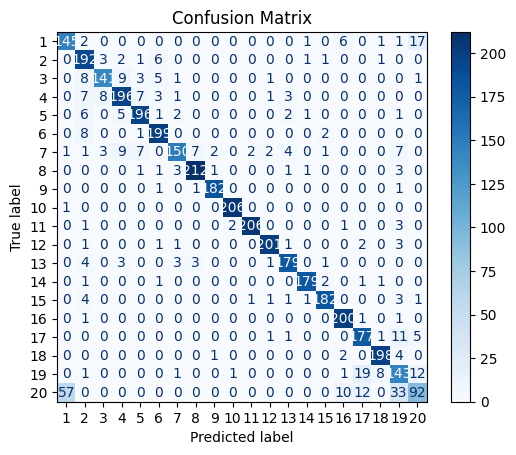

Fold 2/5
Evaluation Metrics: {'accuracy': 0.88625, 'recall': {1: 0.8372093023255814, 2: 0.9179487179487179, 3: 0.8682926829268293, 4: 0.8551401869158879, 5: 0.9282296650717703, 6: 0.9405405405405406, 7: 0.7644230769230769, 8: 0.9329896907216495, 9: 0.9854368932038835, 10: 0.976303317535545, 11: 0.9899497487437185, 12: 0.9558011049723757, 13: 0.8181818181818182, 14: 0.9479166666666666, 15: 0.9534883720930233, 16: 0.9572192513368984, 17: 0.9507389162561576, 18: 0.9234972677595629, 19: 0.7203791469194313, 20: 0.5079365079365079}, 'precision': {1: 0.7468879668049793, 2: 0.8063063063063063, 3: 0.89, 4: 0.8097345132743363, 5: 0.9463414634146341, 6: 0.9405405405405406, 7: 0.9298245614035088, 8: 0.9576719576719577, 9: 0.9950980392156863, 10: 0.9951690821256038, 11: 0.9752475247524752, 12: 0.9010416666666666, 13: 0.8950276243093923, 14: 0.978494623655914, 15: 0.9624413145539906, 16: 0.8994974874371859, 17: 0.8502202643171806, 18: 0.898936170212766, 19: 0.7342995169082126, 20: 0.6193548387096774

<Figure size 1200x1200 with 0 Axes>

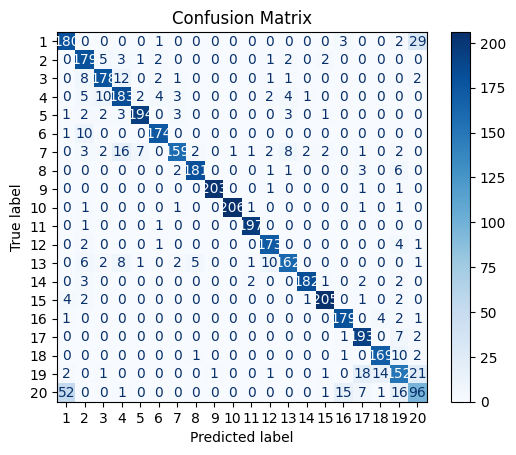

Fold 3/5
Evaluation Metrics: {'accuracy': 0.8917229307326832, 'recall': {1: 0.8238341968911918, 2: 0.8706467661691543, 3: 0.8701923076923077, 4: 0.8950276243093923, 5: 0.9153439153439153, 6: 0.9478672985781991, 7: 0.8078817733990148, 8: 0.9238578680203046, 9: 0.9414414414414415, 10: 0.990521327014218, 11: 0.9748743718592965, 12: 0.9563106796116505, 13: 0.9033816425120773, 14: 0.9441624365482234, 15: 0.9644670050761421, 16: 0.9854368932038835, 17: 0.9367816091954023, 18: 0.961352657004831, 19: 0.7384615384615385, 20: 0.4564102564102564}, 'precision': {1: 0.7293577981651376, 2: 0.8536585365853658, 3: 0.9329896907216495, 4: 0.8059701492537313, 5: 0.9611111111111111, 6: 0.9090909090909091, 7: 0.9265536723163842, 8: 0.9578947368421052, 9: 0.9858490566037735, 10: 0.9858490566037735, 11: 0.9948717948717949, 12: 0.933649289099526, 13: 0.935, 14: 0.9587628865979382, 15: 0.9595959595959596, 16: 0.918552036199095, 17: 0.7990196078431373, 18: 0.908675799086758, 19: 0.6889952153110048, 20: 0.640287

<Figure size 1200x1200 with 0 Axes>

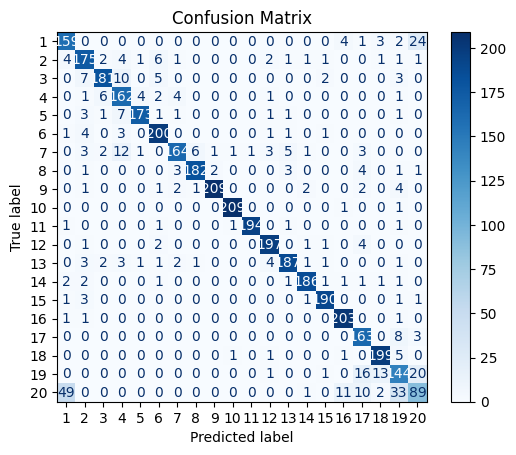

Fold 4/5
Evaluation Metrics: {'accuracy': 0.8912228057014253, 'recall': {1: 0.765, 2: 0.9238095238095239, 3: 0.8653846153846154, 4: 0.9142857142857143, 5: 0.9278350515463918, 6: 0.9226519337016574, 7: 0.7584541062801933, 8: 0.9132653061224489, 9: 0.9885057471264368, 10: 0.9891304347826086, 11: 0.9854368932038835, 12: 0.9675925925925926, 13: 0.9166666666666666, 14: 0.935, 15: 0.964824120603015, 16: 0.976303317535545, 17: 0.9308755760368663, 18: 0.9405940594059405, 19: 0.7777777777777778, 20: 0.5069124423963134}, 'precision': {1: 0.7083333333333334, 2: 0.8508771929824561, 3: 0.9375, 4: 0.7766990291262136, 5: 0.9424083769633508, 6: 0.9226519337016574, 7: 0.9401197604790419, 8: 0.9179487179487179, 9: 0.9555555555555556, 10: 0.994535519125683, 11: 0.9902439024390244, 12: 0.9457013574660633, 13: 0.949238578680203, 14: 0.9842105263157894, 15: 0.9552238805970149, 16: 0.911504424778761, 17: 0.8782608695652174, 18: 0.8962264150943396, 19: 0.6905829596412556, 20: 0.7096774193548387}, 'f1': {1: 0.

<Figure size 1200x1200 with 0 Axes>

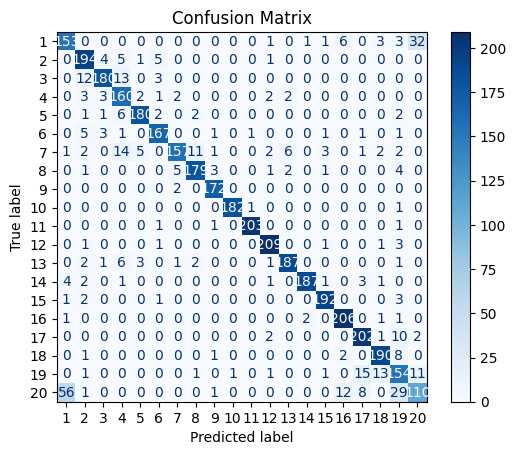

Fold 5/5
Evaluation Metrics: {'accuracy': 0.8884721180295074, 'recall': {1: 0.8401826484018264, 2: 0.8556149732620321, 3: 0.8428571428571429, 4: 0.9117647058823529, 5: 0.9432989690721649, 6: 0.9248826291079812, 7: 0.7311827956989247, 8: 0.9789473684210527, 9: 0.9389671361502347, 10: 0.9679144385026738, 11: 0.9890710382513661, 12: 0.983957219251337, 13: 0.883248730964467, 14: 0.9557522123893806, 15: 0.9128205128205128, 16: 0.9473684210526315, 17: 0.9095238095238095, 18: 0.9556650246305419, 19: 0.8380952380952381, 20: 0.4564102564102564}, 'precision': {1: 0.7698744769874477, 2: 0.7407407407407407, 3: 0.9414893617021277, 4: 0.8303571428571429, 5: 0.9384615384615385, 6: 0.8873873873873874, 7: 0.9379310344827586, 8: 0.93, 9: 0.9900990099009901, 10: 0.9836956521739131, 11: 0.9890710382513661, 12: 0.9246231155778895, 13: 0.9157894736842105, 14: 0.9773755656108597, 15: 0.9834254143646409, 16: 0.8955223880597015, 17: 0.8642533936651584, 18: 0.9065420560747663, 19: 0.7394957983193278, 20: 0.6544

<Figure size 1200x1200 with 0 Axes>

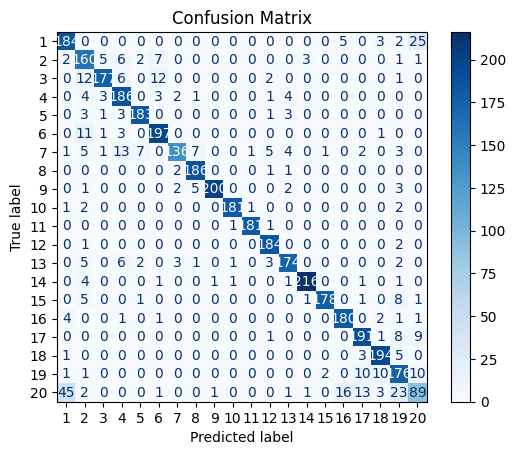

In [120]:
for fold, (train_index, val_index) in enumerate(kf.split(texts_tokenized)):
    print(f'Fold {fold + 1}/{kf.n_splits}')

    X_train = [texts_tokenized[i] for i in train_index]
    y_train = [labels[i] for i in train_index]
    X_val = [texts_tokenized[i] for i in val_index]
    y_val = [labels[i] for i in val_index]

    nb = NaiveBayesClassifier()
    nb.train(X_train, y_train)

    # predictions = nb.predict(X_val)
    # accuracy = sum(p == y for p, y in zip(predictions, y_val)) / len(y_val)
    # print(f'Accuracy: {accuracy:.4f}')
    y_pred, metrics = nb.evaluate(X_val, y_val)
    print("Evaluation Metrics:", metrics)

    # 计算混淆矩阵
    labels_tmp = list(set(y_val))  # 获取所有的类别标签
    cm = confusion_matrix(y_val, y_pred, labels=labels_tmp)

    # 绘制混淆矩阵
    plt.figure(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_tmp)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

In [26]:
def linear_train(X, y, C=1.0, lr=0.001, epochs=10, decay_rate=0.01):
    """
    使用次梯度下降实现线性SVM
    X: 输入特征矩阵 [N, d]
    y: 标签 [N], y in {-1, 1}
    C: 正则化参数
    lr: 初始学习率
    epochs: 训练轮次
    decay_rate: 学习率衰减率
    """
    N, d = X.shape
    w = np.zeros(d)
    b = 0.0
    
    for epoch in range(epochs):
        for i in range(N):
            # 检查是否满足间隔条件 y_i * (w·x_i + b) >= 1
            if y[i] * (np.dot(w, X[i]) + b) < 1:
                # 不满足条件，更新 w 和 b
                w = w - lr * (w - C * y[i] * X[i])
                b = b + lr * C * y[i]
            else:
                # 满足条件，只更新 w
                w = w - lr * w

        # 动态调整学习率
        lr = lr / (1 + epoch * decay_rate)

        # 可选：打印每轮损失值
        hinge_loss = np.maximum(0, 1 - y * (np.dot(X, w) + b)).sum()
        total_loss = 0.5 * np.dot(w, w) + C * hinge_loss
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    return w, b

def linear_predict(X, w, b):
    """预测标签"""
    return np.sign(np.dot(X, w) + b)

In [18]:
def get_sentence_vector(tokens, model, vector_size=300):
    """
    将分词后的文本转换为句向量（平均所有词向量）
    """
    vectors = []
    for token in tokens:
        if token in model:  # 仅考虑在 Word2Vec 模型中的词
            vectors.append(model[token])
    if vectors:
        return np.mean(vectors, axis=0)  # 取词向量的平均值作为句向量
    else:
        return np.zeros(vector_size)  # 如果没有有效词，返回零向量

In [17]:
model_path = "model/GoogleNews-vectors-negative300.bin"
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [19]:
text_vectors = [get_sentence_vector(tokens, word2vec_model) for tokens in texts_tokenized]

In [20]:
print("文档示例（向量化后）：", text_vectors[seed])

文档示例（向量化后）： [ 0.03702893  0.04164494 -0.00339297  0.10327771 -0.05797481  0.00362695
  0.00398566 -0.05252164  0.11535065  0.07739673 -0.04151939 -0.13063034
 -0.03745203  0.00541458 -0.08507212  0.05311555  0.06336398  0.1041673
 -0.0074594  -0.07251099  0.01108381  0.09617541  0.07665242 -0.04780312
  0.01448433 -0.02113957 -0.04798094  0.08734161  0.02988352 -0.0391385
 -0.02242427  0.01134235 -0.03468527 -0.00837082  0.01144839 -0.00549294
 -0.02266864  0.00692601  0.03142103  0.06512199  0.07425934 -0.05392567
  0.12586723 -0.0105989  -0.03468686 -0.03348949 -0.00302887 -0.04234892
  0.0031119   0.00868395 -0.03892561 -0.00705371 -0.00060359  0.04802608
  0.00912757  0.0430563  -0.02471391 -0.06806439  0.04019573 -0.10395502
  0.00166202  0.06144157 -0.08170926 -0.07296216 -0.01939033 -0.058909
 -0.06228344  0.02976975 -0.04588155  0.09609904  0.03397614  0.05859312
  0.06061962  0.01049997 -0.132226   -0.03298084  0.06770325  0.03173221
  0.00672661  0.07934409 -0.01034984 -0.035

In [21]:
print("文档向量维度：", len(text_vectors[seed]))

文档向量维度： 300


In [24]:
X_train, X_test, y_train, y_test = train_test_split(text_vectors, labels, test_size=0.2, random_state=seed)

In [36]:
# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 确保标签为 {-1, 1}
y_train = np.where(y_train == 0, -1, y_train)
y_test = np.where(y_test == 0, -1, y_test)

# print(f"X_train_scaled shape: {X_train_scaled.shape}")
# print(f"y_train shape: {y_train.shape}")

# 训练线性 SVM
w, b = linear_train(X_train_scaled, y_train, C=2, lr=0.0001, epochs=100)

# 预测并计算准确率
svm_preds = linear_predict(X_test_scaled, w, b)
svm_accuracy = np.mean(svm_preds == y_test)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

Epoch 1/100, Loss: 83.9663
Epoch 2/100, Loss: 25.1651
Epoch 3/100, Loss: 14.5168
Epoch 4/100, Loss: 8.9765
Epoch 5/100, Loss: 7.9046
Epoch 6/100, Loss: 4.8993
Epoch 7/100, Loss: 4.0524
Epoch 8/100, Loss: 2.9961
Epoch 9/100, Loss: 3.5001
Epoch 10/100, Loss: 2.2237
Epoch 11/100, Loss: 2.4529
Epoch 12/100, Loss: 1.2413
Epoch 13/100, Loss: 1.3167
Epoch 14/100, Loss: 0.9001
Epoch 15/100, Loss: 1.0856
Epoch 16/100, Loss: 0.7247
Epoch 17/100, Loss: 0.8006
Epoch 18/100, Loss: 0.5647
Epoch 19/100, Loss: 0.5972
Epoch 20/100, Loss: 0.4758
Epoch 21/100, Loss: 0.4150
Epoch 22/100, Loss: 0.3669
Epoch 23/100, Loss: 0.3550
Epoch 24/100, Loss: 0.3354
Epoch 25/100, Loss: 0.3326
Epoch 26/100, Loss: 0.3024
Epoch 27/100, Loss: 0.2960
Epoch 28/100, Loss: 0.2788
Epoch 29/100, Loss: 0.2705
Epoch 30/100, Loss: 0.2729
Epoch 31/100, Loss: 0.2619
Epoch 32/100, Loss: 0.2603
Epoch 33/100, Loss: 0.2584
Epoch 34/100, Loss: 0.2563
Epoch 35/100, Loss: 0.2541
Epoch 36/100, Loss: 0.2534
Epoch 37/100, Loss: 0.2529
Epoch 3

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svm = SVC(kernel='rbf', gamma='scale', C=10.0, random_state=seed)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')

SVM Accuracy: 0.7993


In [121]:
def preprocess_text_simple(text):
    if not isinstance(text, str):
        return []
    words = word_tokenize(text)  # 使用 word_tokenize 分词
    return words

texts_test = [preprocess_text_simple(text) for text in texts]

In [122]:
for fold, (train_index, val_index) in enumerate(kf.split(texts_test)):
    print(f'Fold {fold + 1}/{kf.n_splits}')

    X_train = [texts_test[i] for i in train_index]
    y_train = [labels[i] for i in train_index]
    X_val = [texts_test[i] for i in val_index]
    y_val = [labels[i] for i in val_index]

    nb = NaiveBayesClassifier()
    nb.train(X_train, y_train)

    predictions = nb.predict(X_val)
    accuracy = sum(p == y for p, y in zip(predictions, y_val)) / len(y_val)
    print(f'Accuracy: {accuracy:.4f}')

Fold 1/5
Accuracy: 0.8330
Fold 2/5


KeyboardInterrupt: 